In [1]:
import time
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10
import numpy as np
import matplotlib.pyplot as plt
import json
from datetime import datetime, timedelta
import os
from PIL import Image
if torch.cuda.is_available():
    print(torch.cuda.device_count())
device = torch.device("cuda:2")
print(device)

3
cuda:2


In [2]:
import glob
import re
import json
from pathlib import Path
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [3]:
histwindow = 5 
batchsize = 200
testsize = 10
epochs = 100
allsensors = ('sensor10',  'sensor11', 'sensor15','sensor16', 'sensor20')
fpath = '/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50'

In [4]:
alldata = {}
def sensdata(name):
    jso = open("/proj/NARO/sonoda/orchid/sonoda/{}/all.json".format(name))
    jsl = json.load(jso)
    alldata[name] = jsl
for sname in allsensors:
    sensdata(sname)

In [5]:
files = glob.glob(fpath+'/*.jpg')
sdata = []
fdata = []
tdata = []
for file in files:
    reres = re.findall('.*/data_(20\d\d)(\d\d)(\d\d)_(\d\d)(\d\d)(\d\d).jpg', file)
    (year, month, day, hour, minute, sec) = reres[0]
    dt_date = datetime(int(year), int(month), int(day), int(hour), int(minute), int(sec))
    dt_epoch = int((dt_date.timestamp()+30)/60)*60
    dt_adj = datetime.fromtimestamp(dt_epoch)
    dt_prev = dt_adj
    time_adj = dt_adj.strftime('%Y-%m-%d-%H-%M')
    time_prev = time_adj
    sensd = []
    histerr = 0
    for hist in range(0, histwindow):
        for sname in allsensors:
            if alldata[sname].get(time_prev):
                sensd.append(alldata[sname][time_prev]['Temperature'])
            else:
                histerr = 1
                break
        if histerr:
            break
        dt_prev = dt_prev - timedelta(minutes=1)
        time_prev = dt_prev.strftime('%Y-%m-%d-%H-%M')
    if not histerr:
        sdata.append(sensd)
        tdata.append(time_adj)
        fdata.append(file)

Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20211230_045455.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20220101_201617.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20211229_000241.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20211228_190227.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20220114_100430.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20211229_203439.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20211228_122725.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20220109_084430.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20211228_104203.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20220114_093758.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20220109_191632.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20211229_235441.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20211229_182818.jpg
Error:/auto/

Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20220114_144602.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20220115_185403.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20220109_113428.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20211229_165332.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20220102_005017.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20211230_025345.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20220116_021955.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20211228_204746.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20211229_174055.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20211228_224339.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20220110_075049.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20220115_033010.jpg
Error:/auto/proj/proj/NEDO-VEMS/sonoda/orchid_0_50/data_20211228_141249.jpg
Error:/auto/

In [6]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        self.data_num = len(tdata)
    def __len__(self):
        return self.data_num
    def __getitem__(self, idx):
        image = Image.open(fdata[idx])
#        if self.transform:
#            out_data = self.transform(image)
        out_data = np.array(image).reshape(16*18).astype(np.int32) 
        out_data = out_data*50/255
        return torch.Tensor(sdata[idx]), torch.Tensor(out_data) 
data_set = MyDataset()

In [8]:
def heatmapshow(data):# 多分これはヒートマップを可視化する関数
    im = Image.fromarray(data[0].numpy().reshape([16,18]).copy()*255/50)
    fig, ax = plt.subplots()
    ax.imshow(im, cmap="gray")
    plt.show()

In [14]:
train_size = len(data_set)*0.8
train_size

975.2

In [15]:
from torch.utils.data.dataset import Subset
def split_dataset(data_set, split_at, order=None):#order = Noneは，呼び出し時に指定されなかったらデフォルトで　Noneを使ってねといういう意味
    from torch.utils.data.dataset import Subset
    n_examples = len(data_set)
    if split_at < 0:
        raise ValueError('split_at must be non-negative')
    if split_at > n_examples:
        raise ValueError('split_at exceeds the dataset size')
    if order is not None:
        subset1_indices = order[0:split_at]
        subset2_indices = order[split_at:n_examples]
    else:
        subset1_indices = list(range(0,split_at))
        subset2_indices = list(range(split_at,n_examples))

    subset1 = Subset(data_set, subset1_indices)
    subset2 = Subset(data_set, subset2_indices)
    return subset1, subset2

def split_dataset_random(data_set, first_size, seed=0):
    order = np.random.RandomState(seed).permutation(len(data_set))
    return split_dataset(data_set, int(first_size), order)

In [16]:
test_dataset, data_set = split_dataset_random(data_set, testsize, seed=0)#テストデータ作った
train_dataset, val_dataset = split_dataset_random(data_set, train_size, seed=0)

test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
train_loader = DataLoader(dataset=data_set, batch_size=batchsize, shuffle=True)
val_loader = DataLoader(dataset=data_set, batch_size=batchsize, shuffle=False)

10
1209


In [17]:
class NET(nn.Module):
    def __init__(self):
        super(NET, self).__init__()
        self.fc1 = nn.Linear(xsize, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 16*18)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
model = NET().to(device)
model

NET(
  (fc1): Linear(in_features=25, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=288, bias=True)
)

In [18]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [19]:
train_loss_list = []
val_loss_list = []
t1 = time.time()
for epoch in range(epochs):
    
    model.train()
    train_running_loss = 0
    for batch_idx, (x, c) in enumerate(train_loader):
        x = x.to(device)
        c = c.to(device)
        optimizer.zero_grad()
        y = model(x)
        train_loss = criterion(y, c)
        train_running_loss += train_loss.item()
        train_loss.backward()
        optimizer.step()
    train_loss_list.append(train_loss)
    train_loss = train_running_loss / len(train_loader) 
    
    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for batch_idx, (x, c) in enumerate(val_loader):
            x = x.to(device)
            c = c.to(device)
            y = model(x)
            val_loss = criterion(y, c)
            val_running_loss += val_loss.item()
        val_loss_list.append(val_loss)

    if epoch == 0:
        best_epoch = epoch
        torch.save(model.state_dict(), 'model.pth')
        best_valid_loss = val_running_loss
    else:
        if best_valid_loss > val_running_loss:
            torch.save(model.state_dict(), f"model{epoch}.pth")
            best_valid_loss = val_running_loss
            best_epoch = epoch

    val_loss = val_running_loss / len(val_loader)  
    print('epoch %d, loss: %.4f val_loss: %.4f' % (epoch, train_loss, val_loss))
    
print('best_epoch', best_epoch)
t2 = time.time()
elapsed_time = t2-t1
print(f"経過時間：{elapsed_time}")

epoch 0, loss: 494.3422 val_loss: 489.9701
epoch 1, loss: 484.4959 val_loss: 479.4915
epoch 2, loss: 474.2407 val_loss: 465.9049
epoch 3, loss: 457.2073 val_loss: 446.5934
epoch 4, loss: 435.2407 val_loss: 418.7059
epoch 5, loss: 403.9443 val_loss: 379.5027
epoch 6, loss: 356.7545 val_loss: 326.7678
epoch 7, loss: 299.6420 val_loss: 260.4153
epoch 8, loss: 228.9653 val_loss: 185.2140
epoch 9, loss: 152.2677 val_loss: 113.2866
epoch 10, loss: 90.7938 val_loss: 62.6424
epoch 11, loss: 52.8879 val_loss: 41.9184
epoch 12, loss: 36.6140 val_loss: 34.0972
epoch 13, loss: 27.8542 val_loss: 24.4984
epoch 14, loss: 21.1631 val_loss: 17.1255
epoch 15, loss: 14.3702 val_loss: 14.2571
epoch 16, loss: 13.9245 val_loss: 13.1021
epoch 17, loss: 12.4252 val_loss: 12.4277
epoch 18, loss: 12.7679 val_loss: 12.2001
epoch 19, loss: 11.0654 val_loss: 12.0168
epoch 20, loss: 11.2760 val_loss: 11.8650
epoch 21, loss: 11.2033 val_loss: 11.8455
epoch 22, loss: 11.0636 val_loss: 11.8206
epoch 23, loss: 10.6159 

epoch 199, loss: 6.0854 val_loss: 5.4606
epoch 200, loss: 5.8779 val_loss: 5.4339
epoch 201, loss: 5.8586 val_loss: 5.4574
epoch 202, loss: 6.0510 val_loss: 5.3731
epoch 203, loss: 6.4227 val_loss: 5.3492
epoch 204, loss: 5.6513 val_loss: 5.3053
epoch 205, loss: 5.9695 val_loss: 5.2825
epoch 206, loss: 5.8634 val_loss: 5.2490
epoch 207, loss: 5.4953 val_loss: 5.2551
epoch 208, loss: 5.2584 val_loss: 5.1948
epoch 209, loss: 5.4415 val_loss: 5.1657
epoch 210, loss: 5.5524 val_loss: 5.1446
epoch 211, loss: 5.7611 val_loss: 5.1234
epoch 212, loss: 6.2366 val_loss: 5.1750
epoch 213, loss: 5.2028 val_loss: 5.0499
epoch 214, loss: 5.7925 val_loss: 5.0251
epoch 215, loss: 5.4257 val_loss: 4.9931
epoch 216, loss: 5.6955 val_loss: 4.9534
epoch 217, loss: 5.2887 val_loss: 4.9406
epoch 218, loss: 5.9220 val_loss: 5.0044
epoch 219, loss: 5.6938 val_loss: 5.1223
epoch 220, loss: 5.9633 val_loss: 4.9870
epoch 221, loss: 5.7965 val_loss: 4.8437
epoch 222, loss: 5.5640 val_loss: 4.8467
epoch 223, loss:

epoch 399, loss: 3.3821 val_loss: 2.7719
epoch 400, loss: 3.0277 val_loss: 2.7431
epoch 401, loss: 2.9755 val_loss: 2.7907
epoch 402, loss: 3.2417 val_loss: 2.7331
epoch 403, loss: 2.9279 val_loss: 2.7219
epoch 404, loss: 2.8243 val_loss: 2.7168
epoch 405, loss: 2.8622 val_loss: 2.7327
epoch 406, loss: 2.9746 val_loss: 2.7171
epoch 407, loss: 2.7935 val_loss: 2.7041
epoch 408, loss: 2.7698 val_loss: 2.7061
epoch 409, loss: 3.2771 val_loss: 3.0161
epoch 410, loss: 3.2344 val_loss: 3.2803
epoch 411, loss: 3.4236 val_loss: 2.7307
epoch 412, loss: 3.3757 val_loss: 2.9635
epoch 413, loss: 3.3801 val_loss: 3.1596
epoch 414, loss: 3.0882 val_loss: 2.8769
epoch 415, loss: 3.0024 val_loss: 2.7065
epoch 416, loss: 2.9584 val_loss: 2.6973
epoch 417, loss: 3.0003 val_loss: 2.7356
epoch 418, loss: 3.2153 val_loss: 2.6661
epoch 419, loss: 2.8647 val_loss: 2.8095
epoch 420, loss: 3.1426 val_loss: 2.6951
epoch 421, loss: 2.7661 val_loss: 2.6652
epoch 422, loss: 3.1364 val_loss: 2.6558
epoch 423, loss:

epoch 599, loss: 2.7463 val_loss: 2.5519
epoch 600, loss: 2.5016 val_loss: 2.4322
epoch 601, loss: 2.4706 val_loss: 2.4782
epoch 602, loss: 2.5369 val_loss: 2.7263
epoch 603, loss: 2.9338 val_loss: 2.8457
epoch 604, loss: 2.7460 val_loss: 2.5128
epoch 605, loss: 2.6643 val_loss: 2.4267
epoch 606, loss: 2.6088 val_loss: 2.4504
epoch 607, loss: 4.8621 val_loss: 2.4375
epoch 608, loss: 2.5695 val_loss: 2.4119
epoch 609, loss: 2.6330 val_loss: 2.4129
epoch 610, loss: 2.4357 val_loss: 2.3809
epoch 611, loss: 2.7735 val_loss: 2.3853
epoch 612, loss: 2.4883 val_loss: 2.3764
epoch 613, loss: 2.5336 val_loss: 2.5431
epoch 614, loss: 2.6516 val_loss: 2.4177
epoch 615, loss: 2.4838 val_loss: 2.3903
epoch 616, loss: 2.4418 val_loss: 2.3918
epoch 617, loss: 2.4983 val_loss: 2.3725
epoch 618, loss: 2.6564 val_loss: 2.3657
epoch 619, loss: 2.3954 val_loss: 2.3655
epoch 620, loss: 2.4457 val_loss: 2.4223
epoch 621, loss: 2.7261 val_loss: 2.3832
epoch 622, loss: 2.5867 val_loss: 2.4046
epoch 623, loss:

epoch 799, loss: 2.4446 val_loss: 2.3371
epoch 800, loss: 2.5114 val_loss: 2.1998
epoch 801, loss: 2.2001 val_loss: 2.1753
epoch 802, loss: 2.2208 val_loss: 2.1798
epoch 803, loss: 2.2726 val_loss: 2.1786
epoch 804, loss: 2.3146 val_loss: 2.2179
epoch 805, loss: 2.4883 val_loss: 2.2253
epoch 806, loss: 2.6184 val_loss: 2.2313
epoch 807, loss: 2.2779 val_loss: 2.1939
epoch 808, loss: 2.3655 val_loss: 2.2418
epoch 809, loss: 2.4250 val_loss: 2.1955
epoch 810, loss: 2.1947 val_loss: 2.1715
epoch 811, loss: 2.2841 val_loss: 2.1731
epoch 812, loss: 2.8104 val_loss: 2.4351
epoch 813, loss: 2.4280 val_loss: 2.2230
epoch 814, loss: 2.5159 val_loss: 2.3202
epoch 815, loss: 2.5517 val_loss: 2.1728
epoch 816, loss: 4.4567 val_loss: 2.3856
epoch 817, loss: 2.7787 val_loss: 2.2708
epoch 818, loss: 2.2618 val_loss: 2.2288
epoch 819, loss: 2.3350 val_loss: 2.2957
epoch 820, loss: 2.3689 val_loss: 2.2844
epoch 821, loss: 2.4155 val_loss: 2.1616
epoch 822, loss: 2.9311 val_loss: 2.3308
epoch 823, loss:

epoch 999, loss: 2.1146 val_loss: 1.9965
best_epoch 999
経過時間：689.6964993476868


In [20]:
test_net = NET().to(device)
test_net.eval()
test_net.load_state_dict(torch.load('model' + str(best_epoch) + '.pth'))

<All keys matched successfully>

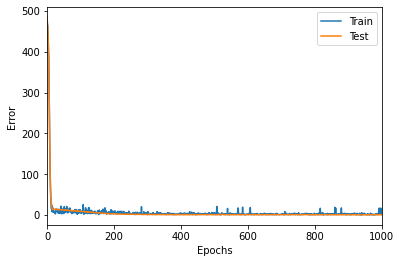

In [21]:
train_loss_list = torch.tensor(train_loss_list)
val_loss_list = torch.tensor(val_loss_list)

plt.xlim(0, 1000)
plt.plot(range(len(train_loss_list)), train_loss_list, label="Train")
plt.plot(range(len(val_loss_list)), val_loss_list, label="Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

In [29]:
import seaborn
def test():
    test_net.eval()
    running_loss = 0
    with torch.no_grad():
        total_max_temp_error = 0
        total_min_temp_error = 0
        max_error_x = 0
        max_error_y = 0
        min_error_x = 0
        min_error_y = 0
        error_per_pix = 0
        loss_sum = 0
        max_error_x_abs = 0
        max_error_y_abs = 0
        min_error_x_abs = 0
        min_error_y_abs = 0
            
        estimate_list = []

        for batch_idx, (x, c) in enumerate(test_loader):
            estimate_start = time.time()
            print('=================================')
            x, c = tmp.next()
            x = x.to(device)
            c = c.to(device)
            y = model(x)
            estimate_end = time.time()
            estimate_duration = -estimate_start+estimate_end
            print("{}個目のモデルの推定時間は：{}秒です".format(batch_idx+1, estimate_duration))
            estimate_list.append(estimate_duration)
            continue
            loss = criterion(y, c)
            loss_unit = torch.sum(torch.abs(y-c))/16/18
            loss_sum = loss_sum + loss_unit
            running_loss += loss.item()
            
            
            y = y.cpu()
            c = c.cpu()
            c_reshaped = c.reshape(16, 18)
            seaborn.heatmap(c_reshaped, vmin=18, vmax=25)
            plt.show()
            y_reshaped = y.reshape(16, 18)
            seaborn.heatmap(y_reshaped, vmin=18, vmax=25)
            plt.show()
            
            #最高温度のずれ
            max_temp_output = torch.max(c)
            max_temp_target = torch.max(y)
            max_temp_error = max_temp_output - max_temp_target
            total_max_temp_error = total_max_temp_error + max_temp_error

            #最低温度のずれ
            min_temp_output = torch.min(c)
            min_temp_target = torch.min(y)
            min_temp_error = min_temp_output - min_temp_target
            total_min_temp_error = total_min_temp_error + min_temp_error

            #最高温度を示すピクセルの座標のずれ(絶対値)
            max_temp_arg = torch.argmax(c)
            max_x_output = (max_temp_arg + 1)%18 -1
            max_y_output = -(max_temp_arg + 1)//18

            max_temp_arg = torch.argmax(y)
            max_x_target = (max_temp_arg + 1)%18 -1
            max_y_target = -(max_temp_arg + 1)//18
            
            max_error_x = max_error_x + abs(max_x_output - max_x_target)
            max_error_y = max_error_y + abs(max_y_output - max_y_target)

            # 最低温度を示すピクセルの座標のずれ(絶対値)
            min_temp_arg = torch.argmin(c)
            min_x_output = (min_temp_arg + 1)%18 -1
            min_y_output = -(min_temp_arg + 1)//18

            min_temp_arg = torch.argmin(y)
            min_x_target = (min_temp_arg + 1)%18 -1
            min_y_target = -(min_temp_arg + 1)//18
            
            min_error_x = min_error_x + abs(min_x_output - min_x_target)
            min_error_y = min_error_y + abs(min_y_output - min_y_target)

    print("平均時間は{}秒です".format(sum(estimate_list)/len(estimate_list)))
    return 0

    print('1ピクセルあたりの誤差', loss_sum/len(test_loader))
    print('最高温度のずれ', total_max_temp_error/len(test_loader))      
    print('最低温度のずれ', total_min_temp_error/len(test_loader))
    print('最高温度を示すピクセルの座標のずれ', max_error_x_abs/len(test_loader), max_error_y_abs/len(test_loader), )
    print('最低温度を示すピクセルの座標のずれ', min_error_x_abs/len(test_loader), min_error_y_abs/len(test_loader), )
    
    print("batch_size: {}　です。頑張ってください".format(batchsize))
    print(fpath)
    p = [loss_sum/len(test_loader), total_max_temp_error/len(test_loader), total_min_temp_error/len(test_loader), max_error_x/len(test_loader), max_error_y/len(test_loader), min_error_x/len(test_loader), min_error_y/len(test_loader), max_error_x_abs/len(test_loader), max_error_y_abs/len(test_loader), min_error_x_abs/len(test_loader), min_error_y_abs/len(test_loader), best_epoch]
    p = [float(x) for x in p]
    p.insert(0, "条件"+str(histwindow))
    print(*p, sep=', ')

    val_loss = running_loss / len(test_loader)

In [31]:
test()

1個目のモデルの推定時間は：0.020036935806274414秒です
2個目のモデルの推定時間は：0.001157999038696289秒です
3個目のモデルの推定時間は：0.001077890396118164秒です
4個目のモデルの推定時間は：0.0016696453094482422秒です
5個目のモデルの推定時間は：0.0010592937469482422秒です
6個目のモデルの推定時間は：0.001722574234008789秒です
7個目のモデルの推定時間は：0.00104522705078125秒です
8個目のモデルの推定時間は：0.0010333061218261719秒です
9個目のモデルの推定時間は：0.001020669937133789秒です
10個目のモデルの推定時間は：0.0011281967163085938秒です
平均時間は0.0030951738357543946秒です


0